In [1]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field
from track_linearization import get_linearized_position
from replay_trajectory_classification import make_track_graph
import numpy as np


def generate_position(traversal_path, track_graph, step_size=0.020, n_traversals=5):
    points = []
    for _ in range(n_traversals):
        for node1, node2 in traversal_path:
            x1, y1 = track_graph.nodes[node1]['pos']
            x2, y2 = track_graph.nodes[node2]['pos']
            dx, dy = x2 - x1, y2 - y1
            dist = np.sqrt(dx**2 + dy**2)
            n_points = int(dist // step_size)
            w = np.linspace(0, 1, n_points)
            points.append((x1 + dx * w, y1 + dy * w))

    return np.concatenate(points, axis=1).T

def get_unique_place_field_centers(place_field_centers):
    return np.unique((place_field_centers * 10_000).astype(int), axis=0) / 10_000

def make_two_environment_data():
    node_positions1 = [(40, 80), # 0
                       (40, 0),  # 1
                       (0, 0),   # 2
                       (0, 80),  # 3
                       (80, 0),  # 4
                       (80, 80), # 5
                       ]
    edges1 = [(0, 1),
             (1, 2),
             (2, 3),
             (1, 4),
             (4, 5)
            ]
    track_graph1 = make_track_graph(node_positions1, edges1)
    
    traversal_path1 = [(0, 1), (1, 2), (2, 3), (3, 2), (2, 1), (1, 0),
                       (0, 1), (1, 4), (4, 5), (5, 4), (4, 1), (1, 0)]
    position1 = generate_position(traversal_path1, track_graph1)

    
    edge_order1 = ((0, 1),
                  (1, 2),
                  (2, 3),
                  (1, 4),
                  (4, 5)
                 )
    edge_spacing1 = (30, 0, 30, 0)
    position_df1 = get_linearized_position(position1,
                                           track_graph1,
                                           edge_order=edge_order1,
                                           edge_spacing=edge_spacing1,
                                           use_HMM=False)
    sampling_frequency = 1000

    place_field_centers1 = generate_position(traversal_path1, track_graph1, step_size=10, n_traversals=1)
    place_field_centers1 = get_unique_place_field_centers(place_field_centers1)
    
    spikes1 = np.stack([simulate_neuron_with_place_field(center, position1,
                                                        sampling_frequency=sampling_frequency,
                                                        variance=6.0**2)
                       for center in place_field_centers1], axis=1)
    
    edges2 = [(0, 1), (1, 2), (2, 3)]
    node_positions2 = [
                   (0, 40),
                   (0, 80),
                   (0, 120),
                   (0, 160),
                   ]
    
    edge_order2 = ((0, 1), (1, 2), (2, 3))
    edge_spacing2 = 0
    track_graph2 = make_track_graph(node_positions2, edges2)
    
    traversal_path2 = [(0, 1), (1, 2), (2, 3),
                       (3, 2), (2, 1), (1, 0)]
    position2 = generate_position(traversal_path2, track_graph2)
    position_df2 = get_linearized_position(position2,
                                          track_graph2,
                                          edge_order=edge_order2,
                                          edge_spacing=edge_spacing2,
                                          use_HMM=False)
    
    place_field_centers2 = generate_position(traversal_path2, track_graph2, step_size=10, n_traversals=1)
    place_field_centers2 = get_unique_place_field_centers(place_field_centers2)
    
    spikes2_temp = np.stack([simulate_neuron_with_place_field(center, position2,
                                                    sampling_frequency=sampling_frequency,
                                                    variance=6.0**2)
                   for center in place_field_centers2], axis=1)
    spikes2 = np.zeros((spikes2_temp.shape[0], spikes1.shape[1]))
    spikes2[:, [7, 17, 27, 4, 14, 24, 10, 1, 12, 23]] = spikes2_temp
    
    return (spikes1, spikes2,
            position_df1, position_df2,
            track_graph1, track_graph2, 
            place_field_centers1, place_field_centers2,
            position1, position2,
            edge_order1, edge_spacing1,
            edge_order2, edge_spacing2
           )

Cupy is not installed or GPU is not detected. Ignore this message if not using GPU


In [2]:
(spikes1, spikes2,
 position_df1, position_df2,
 track_graph1, track_graph2, 
 place_field_centers1, place_field_centers2,
 position1, position2,
 edge_order1, edge_spacing1,
 edge_order2, edge_spacing2,
) = make_two_environment_data()

In [64]:
from replay_trajectory_classification.environments import Environment

env1 = Environment(
    place_bin_size=5,
    track_graph=track_graph1,
    edge_order=edge_order1,
    edge_spacing=edge_spacing1
)

env1.fit_place_grid(position=position_df1.linear_position)

Environment(environment_name='', place_bin_size=5, track_graph=<networkx.classes.graph.Graph object at 0x7ff4245505b0>, edge_order=((0, 1), (1, 2), (2, 3), (1, 4), (4, 5)), edge_spacing=(30, 0, 30, 0), is_track_interior=None, position_range=None, infer_track_interior=True)

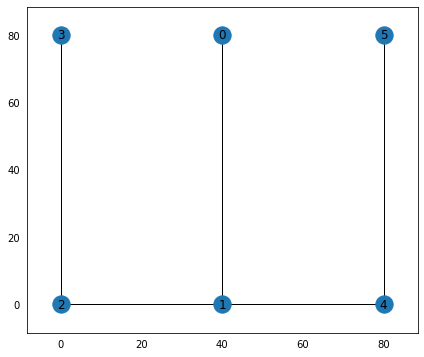

In [49]:
import track_linearization

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
track_linearization.plot_track_graph(track_graph1, ax=ax)
ax.tick_params(labelleft=True, labelbottom=True)

In [28]:
import networkx as nx


laplacian = nx.laplacian_matrix(track_graph1, weight='distance').toarray()
laplacian

array([[ 80., -80.,   0.,   0.,   0.,   0.],
       [-80., 160., -40.,   0., -40.,   0.],
       [  0., -40., 120., -80.,   0.,   0.],
       [  0.,   0., -80.,  80.,   0.,   0.],
       [  0., -40.,   0.,   0., 120., -80.],
       [  0.,   0.,   0.,   0., -80.,  80.]])

In [50]:
nx.laplacian_matrix(track_graph1).toarray()

array([[ 1, -1,  0,  0,  0,  0],
       [-1,  3, -1,  0, -1,  0],
       [ 0, -1,  2, -1,  0,  0],
       [ 0,  0, -1,  1,  0,  0],
       [ 0, -1,  0,  0,  2, -1],
       [ 0,  0,  0,  0, -1,  1]])

In [29]:
norm_laplacian = nx.normalized_laplacian_matrix(track_graph1, weight='distance').toarray()
norm_laplacian

array([[ 1.        , -0.70710678,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.70710678,  1.        , -0.28867513,  0.        , -0.28867513,
         0.        ],
       [ 0.        , -0.28867513,  1.        , -0.81649658,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -0.81649658,  1.        ,  0.        ,
         0.        ],
       [ 0.        , -0.28867513,  0.        ,  0.        ,  1.        ,
        -0.81649658],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.81649658,
         1.        ]])

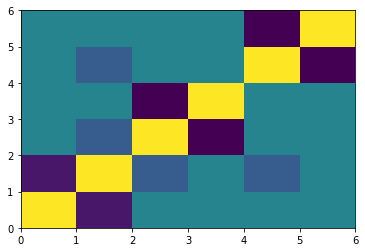

In [17]:
plt.pcolormesh(norm_laplacian.toarray().T)

In [21]:
track_graph1.edges

5

In [23]:
len(track_graph1.nodes)

6

In [24]:
track_graph1.nodes

NodeView((0, 1, 2, 3, 4, 5))

In [90]:
env1.place_bin_centers_nodes_df_.node_id.values

array([  7,   9,  11,  13,  15,  17,  19,  21,  23,  25,  27,  29,  31,
        33,  35,  37,  -1,  40,  42,  44,  46,  48,  50,  52,  54,  74,
        76,  78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100,
       102, 104,  -1,  57,  59,  61,  63,  65,  67,  69,  71, 107, 109,
       111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135,
       137])

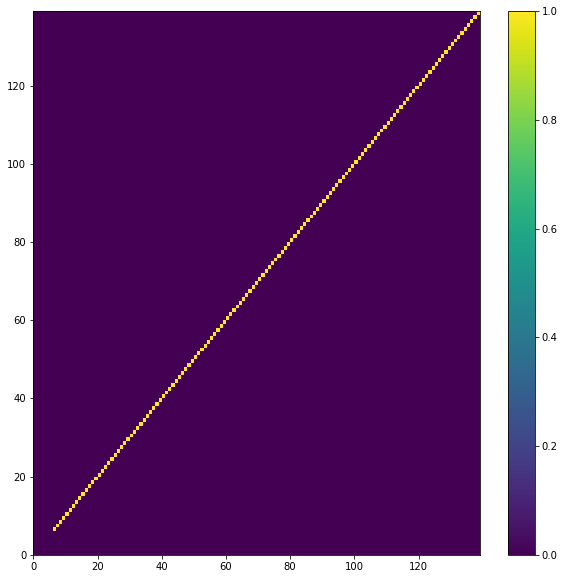

In [104]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(
    nx.normalized_laplacian_matrix(
        env1.track_graph_with_bin_centers_edges_,
        weight='distance',
    ).toarray().T,
    vmin=0.0,
    vmax=1.0,
)
plt.colorbar()

In [83]:
nx.laplacian_matrix(env1.track_graph_with_bin_centers_edges_, weight='distance', nodelist=nodelist).toarray().sum()

0.0

In [96]:
env1.track_graph.